In [12]:
import sys
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import datasets
import time
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

from warnings import simplefilter
simplefilter('ignore', category=UserWarning) # ignore 'fit without feature names' warning
simplefilter('ignore', category=FutureWarning) # ignore XGBoost warning about is_categorical_dtype

In [2]:
full_df = pd.read_csv("https://raw.githubusercontent.com/snwnkang/CS109A_Final/main/data/Milestone4_data/Full_data.csv")
pred = pd.read_csv("https://raw.githubusercontent.com/snwnkang/CS109A_Final/main/data/Milestone4_data/Predictors_data.csv")
resp = pd.read_csv("https://raw.githubusercontent.com/snwnkang/CS109A_Final/main/data/Milestone4_data/Response_data.csv")

In [3]:
#Dropping index columns
full_df = full_df.drop('Unnamed: 0', axis=1)
pred = pred.drop('Unnamed: 0', axis=1)
resp = resp.drop('Unnamed: 0', axis=1)

In [4]:
program_columns = [
    "Courthouse",
    "Full Service Restaurant",
    "Hospital",
    "Large Hotel",
    "Medium Office",
    "Midrise Apartment",
    "Retail",
    "Secondary School",
    "Supermarket",
    "Warehouse",
]

wall_columns = [
    "Mass",
    "Steel framed",
    "Wood framed",
    "Metal",
]

equip_columns = [
    "Packaged Single Zone - gas boiler",
    "Packaged Single Zone - heat pump",
    "Variable Air Volume air-cooled chiller - gas boiler",
    "Variable Air Volume air-cooled chiller - heat pump",
    "Variable Air Volume chiller with central - gas boiler",
    "Variable Air Volume chiller with central - heat pump",
]

<hr>
<hr>
<h1>Extreme Gradient Boosting</h1>
<hr>
<hr>

In [5]:
continuous_columns = [col for col in pred.columns if col not in (program_columns + wall_columns + equip_columns)]

scaler = StandardScaler()

pred[continuous_columns] = scaler.fit_transform(pred[continuous_columns])

pred.head()

,Orientation,nonMassWallR [m^2-K/W],MassWallR [m^2-K/W],RoofR [m^2-K/W],ExteriorFloorR [m^2-K/W],WWRnorth,WWRwest,WWRsouth,WWReast,SHGC,...,Medium Office,Midrise Apartment,Retail,Secondary School,Supermarket,Warehouse,Mass,Steel framed,Wood framed,Metal
0,1.612736,0.336723,-0.394568,1.517794,0.703114,-1.081111,-1.532441,0.240643,-1.381225,0.414473,...,0,0,1,0,0,0,0,0,0,1
1,-0.804851,0.812136,-0.394568,2.825094,1.397133,-0.741229,-1.041839,-0.891804,-0.136095,0.991374,...,0,0,1,0,0,0,0,0,0,1
2,0.020199,-0.118314,-0.394568,-0.254186,-0.397160,-0.514641,-0.551238,0.165147,-1.456687,0.702923,...,0,0,0,0,0,0,1,0,0,0
3,1.718265,-1.619260,2.098007,-0.254186,-0.594646,-0.363582,-0.513500,-0.552070,-0.098364,0.702923,...,0,1,0,0,0,0,1,0,0,0
4,1.315334,-0.247355,-0.394568,-0.948108,0.308144,1.449123,1.448905,1.448588,1.448616,-1.172006,...,1,0,0,0,0,0,0,1,0,0


In [6]:
#XGBoosting can't have special characters in feature names... remove them
pred.columns = [col.replace('[', '').replace(']', '').replace('<', 'lt').replace('-', '').replace(' ', '_') for col in pred.columns]

pred.columns.tolist()

['Orientation',
 'nonMassWallR_m^2K/W',
 'MassWallR_m^2K/W',
 'RoofR_m^2K/W',
 'ExteriorFloorR_m^2K/W',
 'WWRnorth',
 'WWRwest',
 'WWRsouth',
 'WWReast',
 'SHGC',
 'WindowR_m^2K/W',
 'numFloor',
 'AspectRatio',
 'VolumeToFacadeRatio',
 'Packaged_Single_Zone__gas_boiler',
 'Packaged_Single_Zone__heat_pump',
 'Variable_Air_Volume_aircooled_chiller__gas_boiler',
 'Variable_Air_Volume_aircooled_chiller__heat_pump',
 'Variable_Air_Volume_chiller_with_central__gas_boiler',
 'Variable_Air_Volume_chiller_with_central__heat_pump',
 'Courthouse',
 'Full_Service_Restaurant',
 'Hospital',
 'Large_Hotel',
 'Medium_Office',
 'Midrise_Apartment',
 'Retail',
 'Secondary_School',
 'Supermarket',
 'Warehouse',
 'Mass',
 'Steel_framed',
 'Wood_framed',
 'Metal']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(pred, resp.values.ravel(), test_size=0.2, random_state=42)

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

first_mse = mean_squared_error(y_test, y_pred)
first_rmse = mean_squared_error(y_test, y_pred, squared=False)

first_mse, first_rmse

(63.26026731316064, 7.953632334547571)

In [8]:
cv_scores = cross_val_score(xgb_model, pred, resp.values.ravel(), scoring='neg_mean_squared_error', cv=5)
cv_rmse_scores = np.sqrt(-cv_scores)

#Calculate the mean and standard deviation of the cross-validated RMSE scores
cv_rmse_mean = cv_rmse_scores.mean()
cv_rmse_std = cv_rmse_scores.std()

cv_rmse_mean, cv_rmse_std

(7.822520234384726, 0.20010231904277284)

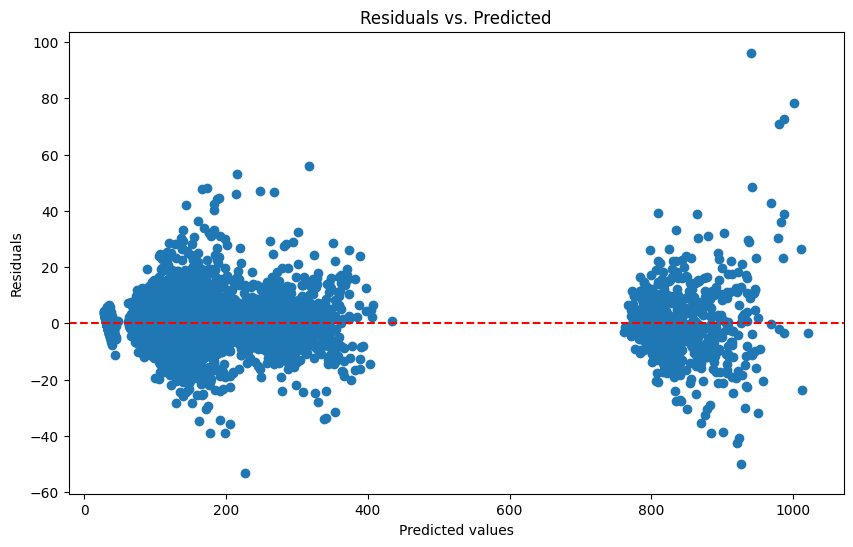

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, (y_test - y_pred))
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

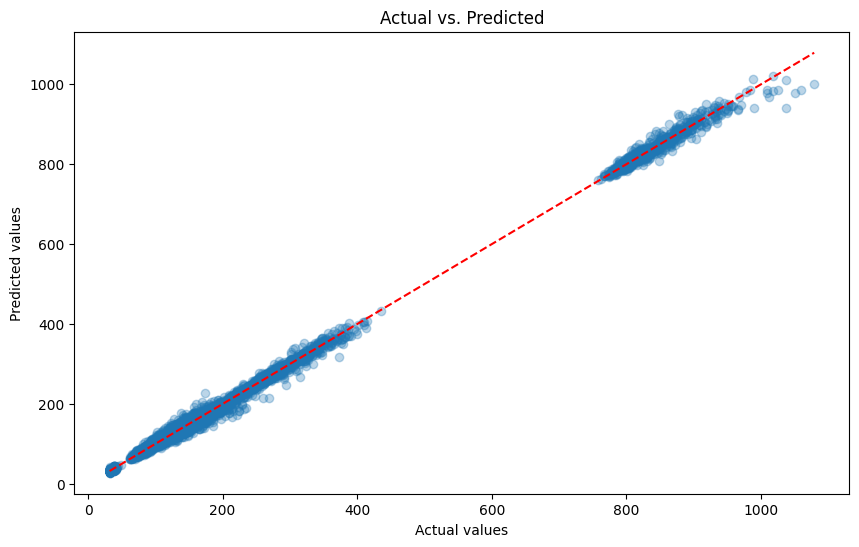

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.title('Actual vs. Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') # Diagonal line
plt.show()

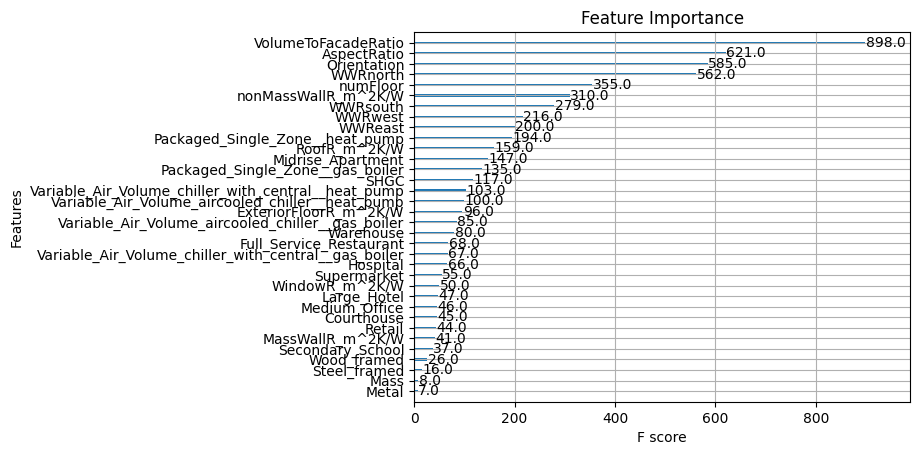

In [13]:
xgb.plot_importance(xgb_model)
plt.title('Feature Importance')
plt.show()

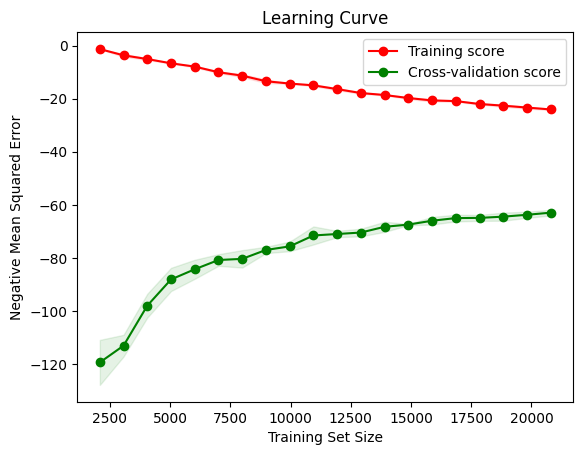

In [14]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error',
    n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 20))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Negative Mean Squared Error")
plt.legend(loc="best")
plt.show()

In [29]:
lc_train_mse = -train_mean[-1]
lc_test_mse = -test_mean[-1]

lc_train_rmse = np.sqrt(lc_train_mse)
lc_test_rmse = np.sqrt(lc_test_mse)

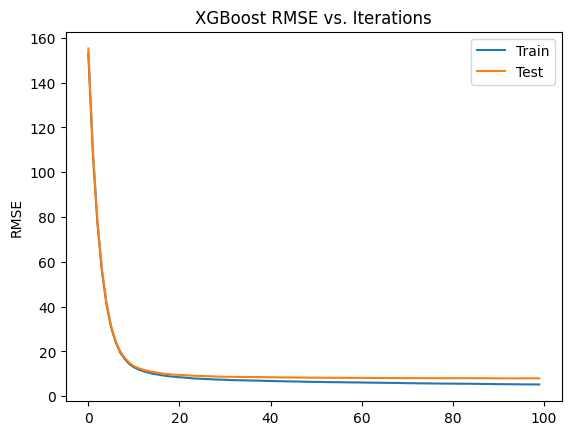

In [18]:
eval_set = [(X_train, y_train), (X_test, y_test)]

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
xgb_model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)

results = xgb_model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE vs. Iterations')
plt.show()

In [19]:
train_rmse_pre_tuned = results['validation_0']['rmse'][-1]
test_rmse_pre_tuned = results['validation_1']['rmse'][-1]

train_mse_pre_tuned = train_rmse_pre_tuned ** 2
test_mse_pre_tuned = test_rmse_pre_tuned ** 2

Refining the model:
<br>
Hyperparameter tuning / Feature Selection

In [20]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

random_search = RandomizedSearchCV(
    estimator = xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions = param_dist,
    n_iter = 10,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    random_state = 42,
    n_jobs = -1
)

random_search.fit(X_train, y_train)

best_parameters = random_search.best_params_
best_rmse = np.sqrt(-random_search.best_score_)

print("Best Parameters:", best_parameters)
print("Best RMSE:", best_rmse)

Best Parameters: {'colsample_bytree': 0.8925879806965068, 'learning_rate': 0.04993475643167195, 'max_depth': 9, 'n_estimators': 343, 'subsample': 0.7962072844310213}
Best RMSE: 7.670419097924025


In [21]:
best_mse = -random_search.best_score_
best_mse, best_rmse

(58.835329137797615, 7.670419097924025)

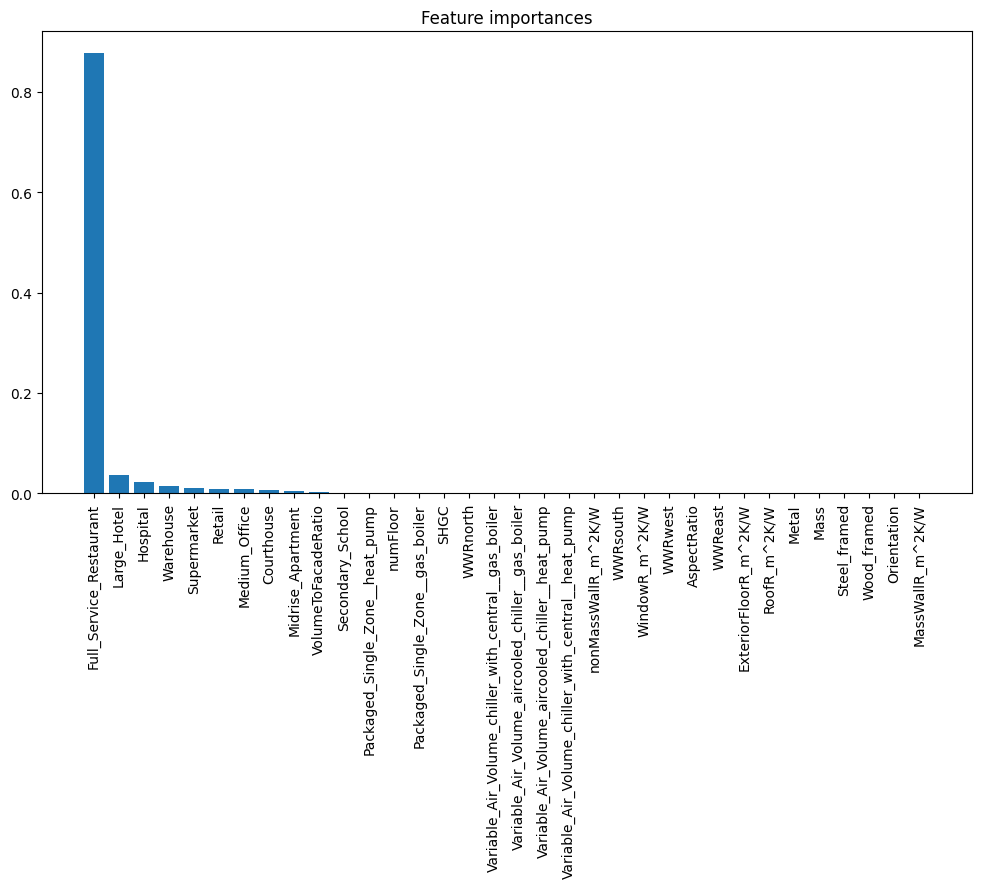

In [26]:
best_model = random_search.best_estimator_

importances = best_model.feature_importances_

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

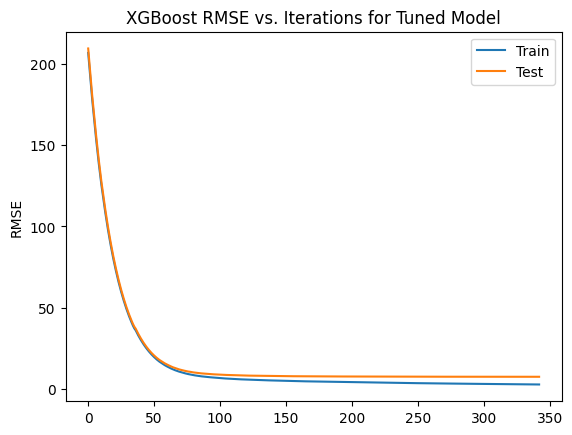

In [27]:
tuned_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=best_parameters['colsample_bytree'],
    learning_rate=best_parameters['learning_rate'],
    max_depth=best_parameters['max_depth'],
    n_estimators=best_parameters['n_estimators'],
    subsample=best_parameters['subsample'],
    random_state=42
)

eval_set = [(X_train, y_train), (X_test, y_test)]
tuned_model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)

results = tuned_model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE vs. Iterations for Tuned Model')
plt.show()

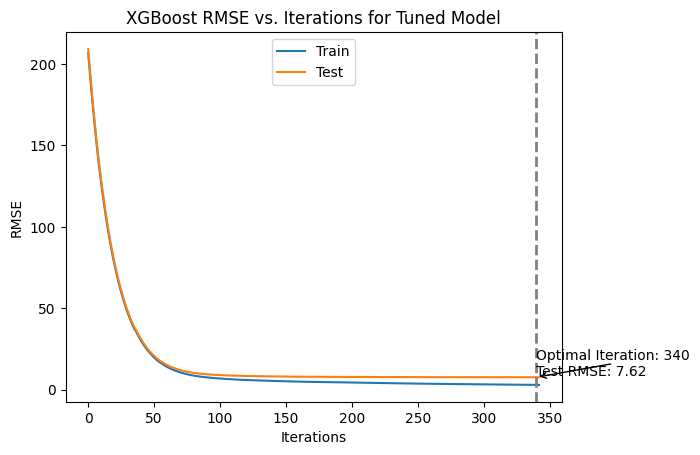

In [28]:
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

optimal_iterations = np.argmin(results['validation_1']['rmse'])
optimal_rmse = np.min(results['validation_1']['rmse'])

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')

ax.axvline(x=optimal_iterations, color='gray', lw=2, linestyle='--')
ax.annotate(f'Optimal Iteration: {optimal_iterations}\nTest RMSE: {optimal_rmse:.2f}',
             xy=(optimal_iterations, optimal_rmse), xycoords='data',
             xytext=(optimal_iterations, optimal_rmse + 1), textcoords='data',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
             )

ax.legend()
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.title('XGBoost RMSE vs. Iterations for Tuned Model')
plt.show()

Please refer to the plot prior to hyperparameter tuning.
After tuning, the RMSE starts much higher, but decreases more smoothly and continues improving across more iterations, marking the optimal iteration at 340 and test RMSE of 7.62. Further from this, the model does not improve, and may overfit if continued.

In [30]:
comparison_df = pd.DataFrame({
    'Model': [
        'Initial Model',
        'Learning Curve (Training)',
        'Learning Curve (Testing)',
        'Pre-tuned Convergence (Training)',
        'Pre-tuned Convergence (Testing)',
        'Post-tuned Convergence'
    ],
    'MSE': [
        first_mse,
        lc_train_mse,
        lc_test_mse,
        train_mse_pre_tuned,
        test_mse_pre_tuned,
        best_mse
    ],
    'RMSE': [
        first_rmse,
        lc_train_rmse,
        lc_test_rmse,
        train_rmse_pre_tuned,
        test_rmse_pre_tuned,
        best_rmse
    ]
})

# Display the dataframe
comparison_df

,Model,MSE,RMSE
0,Initial Model,63.260267,7.953632
1,Learning Curve (Training),24.053649,4.904452
2,Learning Curve (Testing),62.935576,7.933195
3,Pre-tuned Convergence (Training),27.065851,5.202485
4,Pre-tuned Convergence (Testing),63.260267,7.953632
5,Post-tuned Convergence,58.835329,7.670419


Summary Interpretations:

The hyperparameter tuning has improved the model's performance as indicated by a lower RMSE.
The training RMSE during the learning curve phase is significantly better than the initial model, showing that the model is capable of learning effectively.
The testing RMSE has not improved as much from the initial model to the learning curve testing phase, which could imply that the model might still be overfitting or that it has reached a performance plateau.
What is best?

The "Post-tuned Convergence" model has the lowest RMSE at 7.67, making it the best-performing model in terms of error minimization. This model is the most refined version you have and should be the preferred choice for making predictions.